# How to Build a Cohort of Severe COVID-19 Cases Using the MIDRC Data Commons
---
This notebook demonstrates how to build a cohort of severe COVID-19 cases using patient clinical data and AI research-based annotations in the MIDRC data commons.

Our goal is to download structured data and files for 2 related cohorts: 1) severe COVID cases and 2) a control cohort of non-severe COVID cases.

Luckily for the patients, there are many more non-severe cases; but that presents a challenge for building a balanced dataset that is optimal for AI/ML training and evaluation.

* Cohort 1: All chest x-rays (CXR) with an mRALE score of 10 or higher obtained within 2 days after a positive COVID test.

* Cohort 2: Matching number of CXRs with an mRALE score <10 obtained within 2 days after a positive COVID test.

* Additionally, we want the cohorts to be somewhat balanced and matched in terms of the demographics: age, sex, race, and ethnicity.


by Chris Meyer, PhD

Manager of Data and User Services at the Center for Translational Data Science at University of Chicago

August 2023





## 1) Set up Python environment
---


### Set local variables
---
Change the following directory paths to a valid working directories where you're running this notebook.

In [1]:
cred = "/content/credentials.json" # location of your MIDRC credentials, downloaded from https://data.midrc.org/identity by clicking "Create API key" button and saving the credentials.json locally; then upload to Colab Files browser
api = "https://data.midrc.org" # The base URL of the data commons being queried. This shouldn't change for MIDRC.


### Install / Import Python Packages and Scripts

In [2]:
## The packages below may be necessary for users to install according to the imports necessary in the subsequent cells.

import sys
#!{sys.executable} -m pip install
#!{sys.executable} -m pip install --upgrade pandas
#!{sys.executable} -m pip install --upgrade --ignore-installed PyYAML
#!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --upgrade gen3
#!{sys.executable} -m pip install pydicom
#!{sys.executable} -m pip install psmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 11.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

In [3]:
## Import Python Packages and scripts

import os, subprocess
import pandas as pd
import numpy as np
#import pydicom

# import some Gen3 packages
import gen3
from gen3.auth import Gen3Auth
from gen3.query import Gen3Query



### Initiate instances of the Gen3 SDK Classes using credentials file for authentication
---
Again, make sure the "cred" directory path variable reflects the location of your credentials file (path variables set above).

In [4]:
auth = Gen3Auth(api, refresh_file=cred) # authentication class
query = Gen3Query(auth) # query class


## 2) Build Cohorts by Sending Queries to the MIDRC APIs
#### General notes on sending queries:
* There are many ways to query and access metadata for cohort building in MIDRC, but this notebook will focus on using the [Gen3](https://gen3.org) graphQL query service ["guppy"](https://github.com/uc-cdis/guppy/#readme). This is the backend query service that [MIDRC's data explorer GUI](https://data.midrc.org/explorer) uses. So, anything you can do in the explorer GUI, you can do with guppy queries, and more!
* The guppy graphQL service has more functionality than is demonstrated in this simple example with extensive documentation in GitHub [here](https://github.com/uc-cdis/guppy/blob/master/doc/queries.md) in case you'd like to build your own queries from scratch.
* The Gen3 SDK (intialized as "query" above in this notebook) has Python wrapper scripts to make sending queries to the guppy graphQL API simpler. The guppy SDK package can be viewed in GitHub [here](https://github.com/uc-cdis/gen3sdk-python/blob/master/gen3/query.py).
* Guppy queries focus on a particular type of data (cases, imaging studies, files, etc.) and include arguments that are akin to selecting filter values in [MIDRC's data explorer GUI](https://data.midrc.org/explorer).
* To see more documentation about to use and combine filters with various operator logic (like AND/OR/IN, etc.) see [this page](https://github.com/uc-cdis/guppy/blob/master/doc/queries.md#filter).
* We then send our query to MIDRC's guppy API endpoint using [the Gen3Query SDK package](https://github.com/uc-cdis/gen3sdk-python/blob/master/gen3/query.py) we initialized earlier.
* If our query request is successful, the API response should be in JSON format, and it should contain a list of patient IDs along with any other patient data we ask for.

---


#### Cohort 1: All chest x-rays (CXR) with an mRALE score of 10 or higher obtained within 2 days after a positive COVID test.
---

In [5]:
### Set some "imaging_study" query parameters

## mRALE filter: we'll select all imaging studies annotated with an mRAle scores greater than or equal to this threshold number
mRALE_threshold = 10

## days from study to positive COVID-19 test filter: we want imaging studies performed within two days after a positive test
min_days_from_study_to_test = -2
max_days_from_study_to_test = 0

## Imaging study modality filter: we want chest x-rays, so we want studies with a modality of either DX or CR
study_modalities = ["DX", "CR"]

## Imaging study body part filter: here we select "chest" as the "LOINC system" filter, which is the body part examined
body_part_examined = "Chest"



In [6]:
## Note: the "fields" option defines what fields we want the query to return. If set to "None", returns all available fields.

severe_studies = query.raw_data_download(
                    data_type="imaging_study",
                    fields=None,
                    filter_object={
                        "AND": [
                            {"IN": {"loinc_system": [body_part_examined]}},
                            {"IN": {"study_modality": study_modalities}},
                            {"nested": {"path": "imaging_study_annotations", ">=": {"midrc_mRALE_score": mRALE_threshold}}},
                            {"AND": [
                                {">=": {"days_from_study_to_pos_covid_test": min_days_from_study_to_test}},
                                {"<=": {"days_from_study_to_pos_covid_test": max_days_from_study_to_test}}
                            ]}
                        ]
                    },
                    sort_fields=[{"submitter_id": "asc"}]
                )

if len(severe_studies) > 0 and "submitter_id" in severe_studies[0]:
    severe_study_ids = [i['submitter_id'] for i in severe_studies] ## make a list of the imaging study IDs returned
    print("Query returned {} study IDs.".format(len(severe_studies)))
    print("Data is a list with rows like this:\n\t {}".format(severe_studies[0:1]))
else:
    print("Your query returned no data! Please, check that query parameters are valid.")

Query returned 511 study IDs.
Data is a list with rows like this:
	 [{'_imaging_study_id': '9b62b3b6-e20b-4971-a766-41cbc5a8463f', 'project_id': 'Open-R1', 'submitter_id': '1.2.826.0.1.3680043.10.474.419639.128693991392060946362990525434', 'case_ids': ['419639-012029'], 'age_at_imaging': 62, 'body_part_examined': ['CHEST'], 'days_from_study_to_neg_covid_test': [10], 'days_from_study_to_pos_covid_test': [11, -1, -12, -16], 'days_to_study': 16, 'loinc_code': '36572-6', 'loinc_long_common_name': 'XR Chest AP', 'loinc_method': 'XR', 'loinc_system': 'Chest', 'study_description': 'XR CHEST 1 VIEW AP', 'study_modality': ['DX'], 'study_year_shifted': 'true', 'study_uid': '1.2.826.0.1.3680043.10.474.419639.128693991392060946362990525434', 'sex': ['Male'], 'race': ['Not Reported'], 'age_at_index': [62], 'index_event': [], 'zip': ['0'], 'covid19_positive': ['Yes'], 'ethnicity': ['Not Hispanic or Latino'], 'dataset_submitter_id': ['RSNA_20220228'], 'mr_series_file': 1, 'cr_series_file': 1, 'dx_ser

#### Cohort 2: CXRs with an mRALE score <10 obtained within 2 days after a positive COVID test.
---

We don't need to set any new parameters for our filters this time. We just need to reverse the operator on the mRALE threshold from greater than or equal to (`>=`) to less than (`<`).

In [7]:
mild_studies = query.raw_data_download(
                    data_type="imaging_study",
                    fields=None,
                    filter_object={
                        "AND": [
                            {"IN": {"loinc_system": [body_part_examined]}},
                            {"IN": {"study_modality": study_modalities}},
                            {"nested": {"path": "imaging_study_annotations", "<": {"midrc_mRALE_score": mRALE_threshold}}},
                            {"AND": [
                                {">=": {"days_from_study_to_pos_covid_test": min_days_from_study_to_test}},
                                {"<=": {"days_from_study_to_pos_covid_test": max_days_from_study_to_test}}
                            ]}
                        ]
                    },
                    sort_fields=[{"submitter_id": "asc"}]
                )

if len(mild_studies) > 0 and "submitter_id" in mild_studies[0]:
    mild_study_ids = [i['submitter_id'] for i in mild_studies] ## make a list of the imaging study IDs returned
    print("Query returned {} study IDs.".format(len(mild_studies)))
    print("Data is a list with rows like this:\n\t {}".format(mild_studies[0:1]))
else:
    print("Your query returned no data! Please, check that query parameters are valid.")

Query returned 1022 study IDs.
Data is a list with rows like this:
	 [{'_imaging_study_id': '719332ee-e976-44bf-b8d3-f99b568905cb', 'project_id': 'Open-A1', 'submitter_id': '2.16.840.1.114274.1818.538828249250380561516534027591186523540', 'case_ids': ['10008204-KFZf0FscFkWCspd4q8F0ww'], 'age_at_imaging': 24, 'body_part_examined': ['PORT CHEST'], 'days_from_study_to_pos_covid_test': [0], 'days_to_study': 0, 'loinc_code': '36589-0', 'loinc_long_common_name': 'Portable XR Chest AP single view', 'loinc_method': 'XR.portable', 'loinc_system': 'Chest', 'study_description': 'CHEST PORT 1 VIEW (RAD)-CS', 'study_modality': ['CR'], 'study_year_shifted': 'true', 'study_uid': '2.16.840.1.114274.1818.538828249250380561516534027591186523540', 'sex': ['Male'], 'race': ['White'], 'age_at_index': [24], 'index_event': ['First COVID test'], 'zip': ['772'], 'covid19_positive': ['Yes'], 'ethnicity': ['Hispanic or Latino'], 'dataset_submitter_id': ['ACR_20220415'], 'mr_series_file': 1, 'cr_series_file': 1, 

In [8]:
severe_df = pd.DataFrame(severe_studies)
display(severe_df.head())

mild_df = pd.DataFrame(mild_studies)
display(mild_df.head())


,_imaging_study_id,project_id,submitter_id,case_ids,age_at_imaging,body_part_examined,days_from_study_to_neg_covid_test,days_from_study_to_pos_covid_test,days_to_study,loinc_code,...,mr_series_file,cr_series_file,dx_series_file,ct_series_file,object_id,data_format,data_type,data_category,imaging_study_annotations,auth_resource_path
0,9b62b3b6-e20b-4971-a766-41cbc5a8463f,Open-R1,1.2.826.0.1.3680043.10.474.419639.128693991392...,[419639-012029],62,[CHEST],[10],"[11, -1, -12, -16]",16,36572-6,...,1,1,2,1,"[dg.MD1R/dfb34d84-c13c-4574-a6dd-57b5ab1d4d99,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'midrc_mRALE_score': 14, '_annotation_id': '...",/programs/Open/projects/R1
1,6a154323-1a32-4f95-9938-0a8030336db2,Open-A1,2.16.840.1.114274.1818.46358237190008957241551...,[10008204-eb5FvE19O0CsO7VRtLdR1w],45,[PORT CHEST],NaN,[0],0,36589-0,...,1,1,1,1,"[dg.MD1R/ae839f06-f96d-46d4-ba94-f1a60b53c505,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DICOM Annotation Series File, CR, annotation_...","[{'midrc_mRALE_score': 24, '_annotation_id': '...",/programs/Open/projects/A1
2,7416e1ef-eb99-4069-be16-418b94281007,Open-R1,1.2.826.0.1.3680043.10.474.419639.454622325650...,[419639-002636],76,[CHEST],"[3, 0, -7, -106, -301]","[0, -7, -30]",301,36572-6,...,1,1,1,1,"[dg.MD1R/e7f4a28e-d3ad-43d9-9a09-f3317591c9b8,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1
3,714d2489-dbfe-480d-8e90-990e29ae42ec,Open-A1,2.16.840.1.114274.1818.54868557653628095311153...,[10008204-QY84UPKX1ka2LJ1M22pVbg],55,NaN,NaN,[0],0,36589-0,...,1,2,1,1,"[dg.MD1R/6236d1fd-8752-4cea-84ab-317084eb7f57,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[CR, annotation_file]","[{'midrc_mRALE_score': 15, '_annotation_id': '...",/programs/Open/projects/A1
4,073f74f2-2dc3-47f6-bdf1-77a86a9b228a,Open-R1,1.2.826.0.1.3680043.10.474.419639.123288900807...,[419639-006809],64,[CHEST],"[232, 152, 99, 92, 52, -2]","[31, -1]",1,36572-6,...,1,1,1,1,"[dg.MD1R/88f4d961-6428-4154-9c2d-8ec2070eaefa,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DICOM Annotation Series File, CR, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1


,_imaging_study_id,project_id,submitter_id,case_ids,age_at_imaging,body_part_examined,days_from_study_to_pos_covid_test,days_to_study,loinc_code,loinc_long_common_name,...,cr_series_file,dx_series_file,ct_series_file,object_id,data_format,data_type,data_category,imaging_study_annotations,auth_resource_path,days_from_study_to_neg_covid_test
0,719332ee-e976-44bf-b8d3-f99b568905cb,Open-A1,2.16.840.1.114274.1818.53882824925038056151653...,[10008204-KFZf0FscFkWCspd4q8F0ww],24,[PORT CHEST],[0],0,36589-0,Portable XR Chest AP single view,...,1,1,1,"[dg.MD1R/511a136e-dbdc-4ddf-a6bc-c7a8650bca93,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DICOM Annotation Series File, CR, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/A1,NaN
1,3c2ab0e1-fa59-4520-8714-ba7d8fda4451,Open-R1,1.2.826.0.1.3680043.10.474.419639.185292992274...,[419639-006037],53,[CHEST],[0],0,36572-6,XR Chest AP,...,1,1,1,"[dg.MD1R/6b4c92e2-a1b8-438f-9d76-f229574e0fb2,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'midrc_mRALE_score': 8, '_annotation_id': '4...",/programs/Open/projects/R1,NaN
2,c8add295-c084-4c05-ab03-4730eb02cb8f,Open-R1,1.2.826.0.1.3680043.10.474.419639.158367262373...,[419639-002107],33,[CHEST],[-2],20,36572-6,XR Chest AP,...,1,1,1,"[dg.MD1R/2ae926bb-ac0e-46d2-bba1-03f3a731aad6,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'midrc_mRALE_score': 1, '_annotation_id': '5...",/programs/Open/projects/R1,"[513, 304, 163, 96, 3, 2, -19, -20]"
3,0debebc1-504f-42bd-92b9-e86068663c6c,Open-R1,1.2.826.0.1.3680043.10.474.419639.109917025243...,[419639-004439],43,[CHEST],[0],67,36572-6,XR Chest AP,...,1,1,1,"[dg.MD1R/ee6248f7-28da-4447-8ba4-1ae6ff6a93a8,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,"[435, 369, 361, 325, 296, -4, -67, -130]"
4,e560c706-bd03-4698-8e78-cbd8f10ead53,Open-A1,2.16.840.1.114274.1818.53354670098587608501034...,[10008204-lxmdNX4cBkTJXr5O1uQAw],44,NaN,[0],2,36589-0,Portable XR Chest AP single view,...,1,1,1,"[dg.MD1R/4bdf4f30-5f97-4d55-8488-41b779c08f5a,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, annotation_file]","[{'midrc_mRALE_score': 2, '_annotation_id': '1...",/programs/Open/projects/A1,[-2]


In [9]:
## Label cases as mild or severe and then combine the dataframes into a single dataframe
mild_df['cohort'] = 'mild'
severe_df['cohort'] = 'severe'
df = pd.concat([mild_df,severe_df],ignore_index=True)


In [10]:
# convert patient demographic columns in lists to strings
df['case_ids'] = df['case_ids'].apply(lambda x: ','.join(map(str, x)))
df['ethnicity'] = df['ethnicity'].apply(lambda x: ','.join(map(str, x)))
df['race'] = df['race'].apply(lambda x: ','.join(map(str, x)))
df['age_at_index'] = df['age_at_index'].apply(lambda x: ','.join(map(str, x)))
df['age_at_index'] = df['age_at_index'].astype(int)
df['sex'] = df['sex'].apply(lambda x: ','.join(map(str, x)))

# add binned ages for calculating age distributions later
age_bins = np.arange(10,100,10)
df['age_bin'] = pd.cut(df['age_at_index'], bins=age_bins)

In [11]:
# The dataset is inbalanced with more mild COVID patients than severe
df['cohort'].value_counts()

mild      1022
severe     511
Name: cohort, dtype: int64

## 3) Now we use re-sampling techniques to balance the dataset
---
In order to create a mild COVID cohort of the same size as the smaller severe COVID cohort that roughly matches the demographics of the smaller cohort, we need to sample cases from the larger mild COVID cohort through a process called "undersampling" until the size of the two cohorts is equal.

"Undersampling" refers to a group of techniques designed to balance the class distribution for a classification dataset that has a skewed class distribution and is a common technique used in machine learning to balance imbalanced datasets. In this case, we want to undersample the larger patient cohort while ensuring that the resulting two cohorts have a similar distribution of four demographic variables: sex, race, ethnicity, and age.

The following column headers in the Pandas DataFrame we created above will be used for our sampling script: `sex`, `ethnicity`, `race`, and `age_at_index`.

### Calculate the Size of the Smaller Cohort:

Determine the size you want for the smaller cohort. If both cohorts need to be of the same size, you can calculate the size as the minimum size of the two cohorts. You can do this by using the `min` function.


In [12]:
cohorts = ['mild', 'severe']
cohort_sizes = {}
for cohort in cohorts:
    cohort_sizes[cohort] = len(df[df['cohort']==cohort])
display(cohort_sizes)


{'mild': 1022, 'severe': 511}

In [13]:
smaller_cohort_size = min(cohort_sizes.values())
smaller_cohort_name = list(cohort_sizes.keys())[list(cohort_sizes.values()).index(smaller_cohort_size)]
sdf = df.loc[df['cohort']==smaller_cohort_name] # smaller cohort DataFrame

larger_cohort_size = max(cohort_sizes.values())
larger_cohort_name = list(cohort_sizes.keys())[list(cohort_sizes.values()).index(larger_cohort_size)]
ldf = df.loc[df['cohort']==larger_cohort_name] # larger cohort DataFrame

print("The smaller cohort is '{}' with a size of '{}'.".format(smaller_cohort_name,smaller_cohort_size))
print("The larger cohort is '{}' with a size of '{}'.".format(larger_cohort_name,larger_cohort_size))

The smaller cohort is 'severe' with a size of '511'.
The larger cohort is 'mild' with a size of '1022'.


### Undersampling:

Now, we undersample the larger cohort to match the smaller cohort's size while maintaining the desired distribution of demographic variables. For this, we'll use the `sample` function in Pandas.

To use the Pandas `sample` function to undersample the larger cohort (mild COVID cases) while considering the four demographic variables and their distribution in the smaller cohort (severe COVID cases), you can create a custom sampling probability based on the distribution of the smaller cohort.

#### Strategy
---
1) Determine the frequency of all combinations of demographic properties in the smaller cohort,
2) Add this frequency to each row in the larger cohort by matching the demographics combinations, and
3) Undersample the larger cohort using the inverse of these frequencies as weights


In [14]:
# Make a list of all combinations of demographic variables found in the master DataFrame using pd.value_counts()

# list of properties to consider (dprops: "demographic properties")
#dprops = ['sex','ethnicity']
dprops = ['sex','ethnicity','race','age_bin']

print("Counts of Demographic Property Combinations in Master DataFrame:")
mvc = df[dprops].value_counts() # mvc: "master value counts"
#mvc[('Male', 'Not Hispanic or Latino')] # this is how you access individual values
display(mvc)

print("\nAll Combinations of Demographic Properties in Master DataFrame:")
combos = mvc.index.tolist()
display(combos)


Counts of Demographic Property Combinations in Master DataFrame:


sex           ethnicity               race                                       age_bin 
Male          Not Hispanic or Latino  Not Reported                               (60, 70]    79
                                      White                                      (60, 70]    77
                                      Not Reported                               (50, 60]    64
                                      White                                      (70, 80]    60
              Hispanic or Latino      Not Reported                               (50, 60]    47
                                                                                             ..
              Not Hispanic or Latino                                             (70, 80]     1
                                      Not Reported                               (10, 20]     1
                                      Native Hawaiian or other Pacific Islander  (50, 60]     1
                                              


All Combinations of Demographic Properties in Master DataFrame:


[('Male',
  'Not Hispanic or Latino',
  'Not Reported',
  Interval(60, 70, closed='right')),
 ('Male', 'Not Hispanic or Latino', 'White', Interval(60, 70, closed='right')),
 ('Male',
  'Not Hispanic or Latino',
  'Not Reported',
  Interval(50, 60, closed='right')),
 ('Male', 'Not Hispanic or Latino', 'White', Interval(70, 80, closed='right')),
 ('Male',
  'Hispanic or Latino',
  'Not Reported',
  Interval(50, 60, closed='right')),
 ('Female',
  'Not Hispanic or Latino',
  'White',
  Interval(80, 90, closed='right')),
 ('Male', 'Not Hispanic or Latino', 'White', Interval(50, 60, closed='right')),
 ('Male',
  'Not Hispanic or Latino',
  'Not Reported',
  Interval(40, 50, closed='right')),
 ('Female',
  'Not Hispanic or Latino',
  'White',
  Interval(70, 80, closed='right')),
 ('Male', 'Not Hispanic or Latino', 'White', Interval(80, 90, closed='right')),
 ('Female',
  'Not Hispanic or Latino',
  'White',
  Interval(60, 70, closed='right')),
 ('Male',
  'Not Hispanic or Latino',
  'Not Rep

In [15]:
# Now look at the frequencies of each demographic combo in the smaller cohort
svc = sdf[dprops].value_counts(normalize=False).reindex(combos) # svc: "smaller cohort value counts"
print("Smaller Cohort Demographics Value Counts\n{}\n\n".format(svc))

# use normalize=True to get the relative frequencies (count of a demographic / sum of all demographics)
svf = sdf[dprops].value_counts(normalize=True).reindex(combos) # svf: "smaller cohort value frequencies"
print("Smaller Cohort Demographics Frequencies\n{}\n\n".format(svf))

# sampling weights should be the inverse of their frequencies; less frequent demographics get a higher probability of sampling
svw = 1/svf # svw: "smaller cohort value weights"
print("Smaller Cohort Demographics Weights for Undersampling\n{}\n\n".format(svw))

Smaller Cohort Demographics Value Counts
sex           ethnicity               race                                       age_bin 
Male          Not Hispanic or Latino  Not Reported                               (60, 70]    18.0
                                      White                                      (60, 70]    28.0
                                      Not Reported                               (50, 60]    32.0
                                      White                                      (70, 80]    23.0
              Hispanic or Latino      Not Reported                               (50, 60]    16.0
                                                                                             ... 
              Not Hispanic or Latino                                             (70, 80]     NaN
                                      Not Reported                               (10, 20]     NaN
                                      Native Hawaiian or other Pacific Islander  (50,

Demographics in the larger cohort not represented in the smaller cohort get NaN for counts. Here we'll convert the `NaN`s to `0` to use as weights:

In [16]:
# Replace NaNs with 0:
for key in list(svw.keys()):
    if np.isnan(svw[key]):
        svw[key] = 0
display(svw)

sex           ethnicity               race                                       age_bin 
Male          Not Hispanic or Latino  Not Reported                               (60, 70]    28.388889
                                      White                                      (60, 70]    18.250000
                                      Not Reported                               (50, 60]    15.968750
                                      White                                      (70, 80]    22.217391
              Hispanic or Latino      Not Reported                               (50, 60]    31.937500
                                                                                               ...    
              Not Hispanic or Latino                                             (70, 80]     0.000000
                                      Not Reported                               (10, 20]     0.000000
                                      Native Hawaiian or other Pacific Islander  (50, 

In [17]:
# Now apply the weights to each row of the larger cohort (mild COVID cases) to use in undersampling
for combo in combos:
    print("{}: {}".format(combo,svw[combo]))
    ldf.loc[(ldf[dprops[0]] == combo[0]) & (ldf[dprops[1]] == combo[1]) & (ldf[dprops[2]] == combo[2]) & (ldf[dprops[3]] == combo[3]),'weight'] = svw[combo]


('Male', 'Not Hispanic or Latino', 'Not Reported', Interval(60, 70, closed='right')): 28.38888888888889
('Male', 'Not Hispanic or Latino', 'White', Interval(60, 70, closed='right')): 18.25
('Male', 'Not Hispanic or Latino', 'Not Reported', Interval(50, 60, closed='right')): 15.96875
('Male', 'Not Hispanic or Latino', 'White', Interval(70, 80, closed='right')): 22.217391304347828
('Male', 'Hispanic or Latino', 'Not Reported', Interval(50, 60, closed='right')): 31.9375
('Female', 'Not Hispanic or Latino', 'White', Interval(80, 90, closed='right')): 34.06666666666667
('Male', 'Not Hispanic or Latino', 'White', Interval(50, 60, closed='right')): 34.06666666666667
('Male', 'Not Hispanic or Latino', 'Not Reported', Interval(40, 50, closed='right')): 23.22727272727273
('Female', 'Not Hispanic or Latino', 'White', Interval(70, 80, closed='right')): 46.45454545454546
('Male', 'Not Hispanic or Latino', 'White', Interval(80, 90, closed='right')): 51.1
('Female', 'Not Hispanic or Latino', 'White',

<ipython-input-17-e31a11de7ca1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf.loc[(ldf[dprops[0]] == combo[0]) & (ldf[dprops[1]] == combo[1]) & (ldf[dprops[2]] == combo[2]) & (ldf[dprops[3]] == combo[3]),'weight'] = svw[combo]



('Male', 'Not Hispanic or Latino', 'Asian', Interval(70, 80, closed='right')): 170.33333333333334
('Male', 'Hispanic or Latino', 'White', Interval(60, 70, closed='right')): 51.1
('Male', 'Hispanic or Latino', 'White', Interval(50, 60, closed='right')): 56.77777777777778
('Female', 'Hispanic or Latino', 'White', Interval(30, 40, closed='right')): 127.75
('Female', 'Not Hispanic or Latino', 'Not Reported', Interval(50, 60, closed='right')): 0.0
('Male', 'Hispanic or Latino', 'Not Reported', Interval(20, 30, closed='right')): 127.75
('Male', 'Hispanic or Latino', 'Not Reported', Interval(40, 50, closed='right')): 63.875
('Female', 'Hispanic or Latino', 'Not Reported', Interval(20, 30, closed='right')): 102.2
('Female', 'Not Hispanic or Latino', 'Not Reported', Interval(80, 90, closed='right')): 102.2
('Male', 'Hispanic or Latino', 'Not Reported', Interval(30, 40, closed='right')): 127.75
('Female', 'Not Hispanic or Latino', 'Asian', Interval(80, 90, closed='right')): 127.75
('Male', 'His

In [18]:
# Double check that all rows in the larger cohort were assigned a weight. If this is an empty DataFrame, then each row has a non-NaN weight.
ldf.loc[ldf['weight'].isna()]

,_imaging_study_id,project_id,submitter_id,case_ids,age_at_imaging,body_part_examined,days_from_study_to_pos_covid_test,days_to_study,loinc_code,loinc_long_common_name,...,object_id,data_format,data_type,data_category,imaging_study_annotations,auth_resource_path,days_from_study_to_neg_covid_test,cohort,age_bin,weight


### Undersample the Larger Cohort:

Use the `sample` function with the calculated weights to undersample the larger cohort.

In [19]:
# Undersample the larger cohort (mild COVID cases) using weights

udf = ldf.sample(n=smaller_cohort_size, weights=ldf['weight'], random_state=np.random.RandomState(41)) # undersampled larger cohort DataFrame, can set random_state in order to have reproducible sampling
#udf = ldf.sample(n=smaller_cohort_size, weights=ldf['weight']) # undersampled larger cohort DataFrame, leave random_state out to get a non-reproducible, random sample
udf.reset_index(drop=True,inplace=True)
udf

,_imaging_study_id,project_id,submitter_id,case_ids,age_at_imaging,body_part_examined,days_from_study_to_pos_covid_test,days_to_study,loinc_code,loinc_long_common_name,...,object_id,data_format,data_type,data_category,imaging_study_annotations,auth_resource_path,days_from_study_to_neg_covid_test,cohort,age_bin,weight
0,95bbd25c-8251-437b-be4f-564b7f4b25ef,Open-R1,1.2.826.0.1.3680043.10.474.419639.128367822495...,419639-004292,66,[CHEST],"[14, 4, 0]",0,36572-6,XR Chest AP,...,"[dg.MD1R/28d38eaa-1d19-4639-be7c-a88f90943988,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,"[203, 199, 87, 86, 68, -92]",mild,"(60, 70]",36.500000
1,71a56b0e-be90-4ec7-9659-e66dd96db55f,Open-R1,1.2.826.0.1.3680043.10.474.419639.122778105636...,419639-006881,76,[CHEST],[0],0,36572-6,XR Chest AP,...,"[dg.MD1R/bf09e011-241e-4e68-b962-ec1b24ae1daf,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,"[197, 193, -213]",mild,"(70, 80]",85.166667
2,607c354e-4e75-4f5c-8588-055345d58f06,Open-R1,1.2.826.0.1.3680043.10.474.419639.844735511217...,419639-007659,37,[CHEST],"[0, -19]",19,36572-6,XR Chest AP,...,"[dg.MD1R/2e423cae-28ba-4513-923e-caca8a207818,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DICOM Annotation Series File, CR, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,NaN,mild,"(30, 40]",127.750000
3,280bb1a6-4203-42c9-8140-4dd1606bbee0,Open-R1,1.2.826.0.1.3680043.10.474.419639.240833311849...,419639-006705,76,[CHEST],[0],0,36572-6,XR Chest AP,...,"[dg.MD1R/7839bb7a-a94d-4122-b1bc-c81fe98799f3,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,NaN,mild,"(70, 80]",170.333333
4,9b1fedc4-72a1-4a3d-ad0c-6b4792088de6,Open-R1,1.2.826.0.1.3680043.10.474.419639.126712353062...,419639-005373,25,[CHEST],[0],0,36572-6,XR Chest AP,...,"[dg.MD1R/f6b97cfa-0c69-45fc-9792-7dfb1b4f4baf,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,[22],mild,"(20, 30]",127.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,d0860f6b-7122-40a6-8b4a-c9e756a4405c,Open-A1,2.16.840.1.114274.1818.56650439505816486664956...,10008204-rqH71qqQDEOgPbiZuFiaXA,60,[PORT CHEST],[0],0,36589-0,Portable XR Chest AP single view,...,"[dg.MD1R/abf9d7b7-6b02-4c66-9547-c1b9f63fdd56,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DICOM Annotation Series File, CR, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/A1,NaN,mild,"(50, 60]",63.875000
507,7267e056-85f9-485d-a1fe-3e20ab0b18d7,Open-R1,1.2.826.0.1.3680043.10.474.419639.211614809882...,419639-004031,85,[CHEST],"[38, 24, 19, 12, 0]",0,36572-6,XR Chest AP,...,"[dg.MD1R/14bc22bf-fe61-4fb0-88be-12204076b9a6,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DICOM Annotation Series File, CR, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,[30],mild,"(80, 90]",127.750000
508,930b1bb9-dc44-49e0-a594-83dc42a96e0d,Open-R1,1.2.826.0.1.3680043.10.474.419639.736562568906...,419639-006220,54,[CHEST],[0],0,36572-6,XR Chest AP,...,"[dg.MD1R/42bef98e-6e68-4387-93ac-487e4c162282,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DICOM Annotation Series File, CR, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,NaN,mild,"(50, 60]",34.066667
509,331ef4bb-c256-463b-8917-48c9b847fb1d,Open-R1,1.2.826.0.1.3680043.10.474.419639.893821260712...,419639-006440,85,[CHEST],[0],0,36572-6,XR Chest AP,...,"[dg.MD1R/bf53adea-3b4b-428b-9dff-50506e3936e5,...","[CSV, 

### Combine the Two Cohorts:

After undersampling, you'll have two cohorts of the same size, and the larger cohort should be balanced with respect to the four demographic variables.


In [20]:
# Combine the undersampled larger cohort with the smaller cohort
bdf = pd.concat([udf.drop(columns=["weight"]), sdf]).reset_index(drop=True) # balanced DataFrame
bdf

,_imaging_study_id,project_id,submitter_id,case_ids,age_at_imaging,body_part_examined,days_from_study_to_pos_covid_test,days_to_study,loinc_code,loinc_long_common_name,...,ct_series_file,object_id,data_format,data_type,data_category,imaging_study_annotations,auth_resource_path,days_from_study_to_neg_covid_test,cohort,age_bin
0,95bbd25c-8251-437b-be4f-564b7f4b25ef,Open-R1,1.2.826.0.1.3680043.10.474.419639.128367822495...,419639-004292,66,[CHEST],"[14, 4, 0]",0,36572-6,XR Chest AP,...,1,"[dg.MD1R/28d38eaa-1d19-4639-be7c-a88f90943988,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,"[203, 199, 87, 86, 68, -92]",mild,"(60, 70]"
1,71a56b0e-be90-4ec7-9659-e66dd96db55f,Open-R1,1.2.826.0.1.3680043.10.474.419639.122778105636...,419639-006881,76,[CHEST],[0],0,36572-6,XR Chest AP,...,1,"[dg.MD1R/bf09e011-241e-4e68-b962-ec1b24ae1daf,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,"[197, 193, -213]",mild,"(70, 80]"
2,607c354e-4e75-4f5c-8588-055345d58f06,Open-R1,1.2.826.0.1.3680043.10.474.419639.844735511217...,419639-007659,37,[CHEST],"[0, -19]",19,36572-6,XR Chest AP,...,1,"[dg.MD1R/2e423cae-28ba-4513-923e-caca8a207818,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DICOM Annotation Series File, CR, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,NaN,mild,"(30, 40]"
3,280bb1a6-4203-42c9-8140-4dd1606bbee0,Open-R1,1.2.826.0.1.3680043.10.474.419639.240833311849...,419639-006705,76,[CHEST],[0],0,36572-6,XR Chest AP,...,1,"[dg.MD1R/7839bb7a-a94d-4122-b1bc-c81fe98799f3,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,NaN,mild,"(70, 80]"
4,9b1fedc4-72a1-4a3d-ad0c-6b4792088de6,Open-R1,1.2.826.0.1.3680043.10.474.419639.126712353062...,419639-005373,25,[CHEST],[0],0,36572-6,XR Chest AP,...,1,"[dg.MD1R/f6b97cfa-0c69-45fc-9792-7dfb1b4f4baf,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,[22],mild,"(20, 30]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,bf9a1daf-5447-447a-9199-bf81c5265604,Open-R1,1.2.826.0.1.3680043.10.474.419639.179077861710...,419639-010413,37,[CHEST],[0],0,36572-6,XR Chest AP,...,1,"[dg.MD1R/8f2c31c7-2751-49f5-bb83-8e03a68b9b24,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'midrc_mRALE_score': 24, '_annotation_id': '...",/programs/Open/projects/R1,NaN,severe,"(30, 40]"
1018,fa2e8f47-3e76-4ef0-9afe-6417f55525e5,Open-R1,1.2.826.0.1.3680043.10.474.419639.240842622217...,419639-007069,54,[CHEST],"[-1, -9, -24]",24,36572-6,XR Chest AP,...,1,"[dg.MD1R/52e00dab-545b-457d-b504-14fa3f498f5a,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'annotation_method': 'Retrospective_auto', '...",/programs/Open/projects/R1,"[105, 25]",severe,"(50, 60]"
1019,feb4d730-720b-488c-8936-d0545f4934db,Open-R1,1.2.826.0.1.3680043.10.474.419639.283320921206...,419639-004507,56,[CHEST],"[-2, -3]",3,36572-6,XR Chest AP,...,1,"[dg.MD1R/8f53ecea-28e3-4a58-bf5c-833653cca8e3,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series File, annotation_...","[{'midrc_mRALE_score': 15, '_annotation_id': '...",/programs/Open/projects/R1,"[-136, -144]",severe,"(50, 60]"
1020,e2a3df0d-7246-4f08-971d-cd7b309fdaf7,Open-R1,1.2.826.0.1.3680043.10.474.419639.310060048562...,419639-007176,50,[CHEST],"[28, 0]",0,36572-6,XR Chest AP,...,1,"[dg.MD1R/053cb2b5-9f8b-43db-870a-98b8e53cc2f7,...","[CSV, DCM]","[MIDRC Annotation, DICOM]","[DX, DICOM Annotation Series Fi

## 4) Verification:

Ensure that the demographic distributions of the two cohorts are now balanced for all four variables. You can use the `pandas` `groupby` and `value_counts` methods or other appropriate methods to check the distributions.


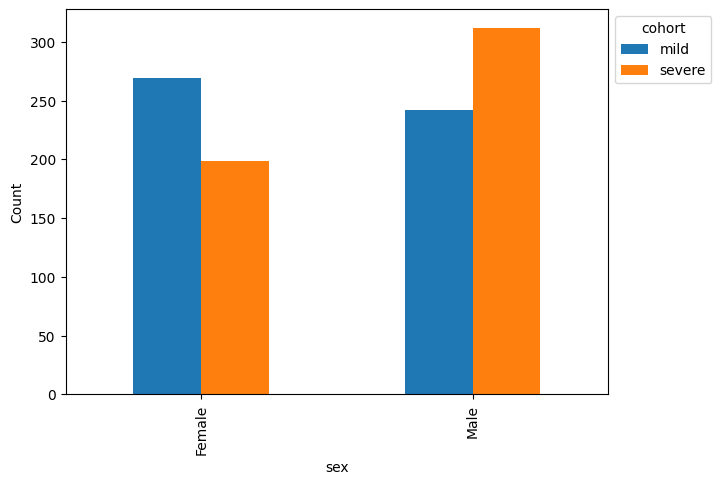

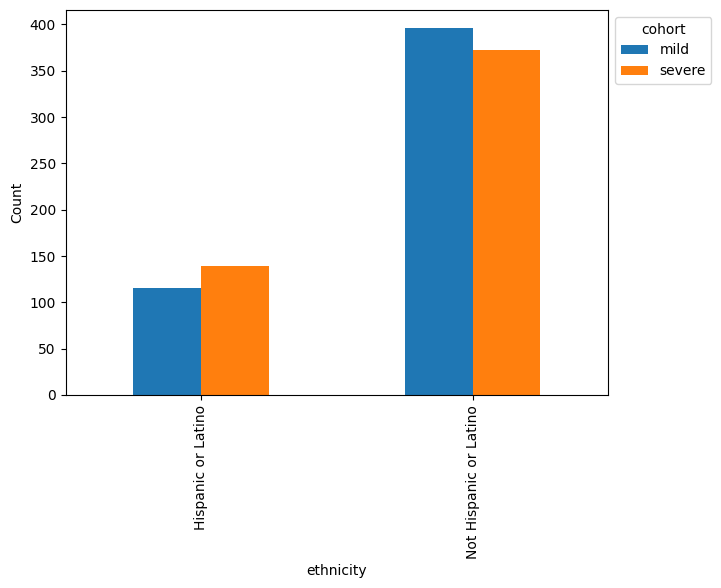

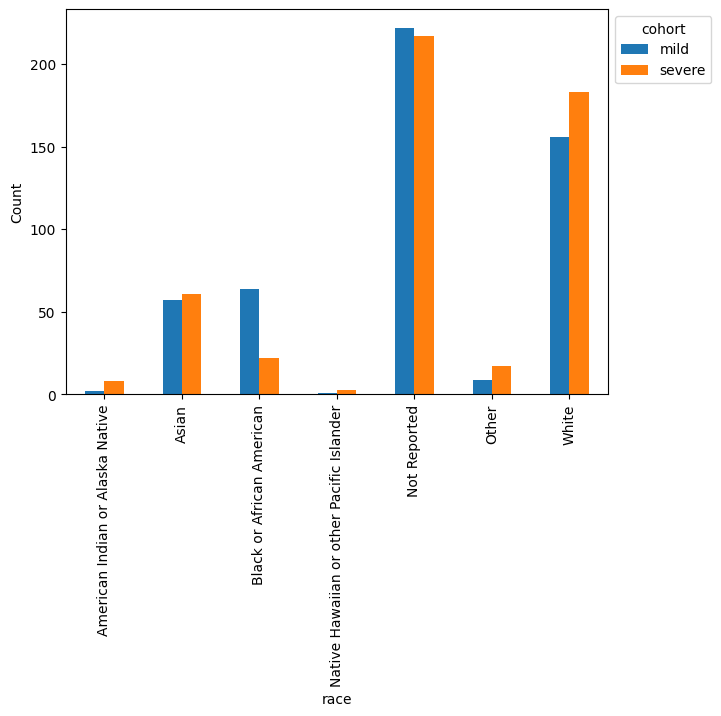

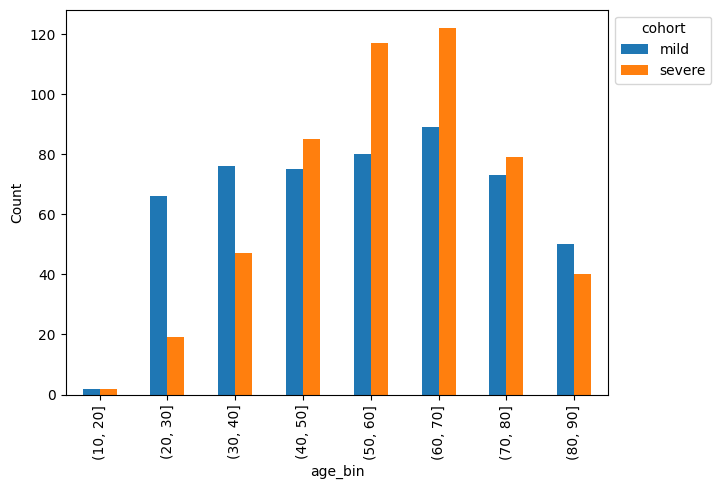

In [21]:
# Use pandas groupby and plot functions to view relative counts of different demographics in the balanced cohort
for prop in dprops:
  dfu = bdf.groupby([prop],observed=True).cohort.value_counts().unstack()
  ax = dfu.plot(kind='bar', figsize=(7, 5), xlabel=prop, ylabel='Count', rot=90) # change rot=0 or rot=45 to change x-axis label display angle
  ax.legend(title='cohort', bbox_to_anchor=(1, 1), loc='upper left')

## The End
---
If you have any questions related to this notebook don't hesitate to reach out to the MIDRC Helpdesk at midrc-support@datacommons.io or the author directly at cgmeyer@uchicago.edu

Happy data wrangling!